In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import ast
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchmetrics import F1Score,ConfusionMatrix,ROC,PrecisionRecallCurve
from sklearn.metrics import ConfusionMatrixDisplay
import copy
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

import torchvision

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <5397CDCC-E7C1-3D37-AC7B-96BB2EB7D198> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <1E9FA061-EA31-3736-81D0-79A33B965097> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class RandomGammaCorrection(nn.Module):
    """
    Apply Gamma Correction to the images
    """
    def __init__(self, gamma_range=(0.5, 2.0)):
        self.gamma_range = gamma_range

    def __call__(self, img):
        #sample log uniformly in range [log(gamma_range[0]), log(gamma_range[1])]
        gamma = np.random.uniform(self.gamma_range[0], self.gamma_range[1])
        return torchvision.transforms.functional.adjust_gamma(img, gamma)

    def forward(self, img):
        return self.__call__(img)

    def __repr__(self):
        return self.__class__.__name__ + '(gamma_range={0})'.format(self.gamma_range)

In [17]:
# Define the input size and number of classes
input_size = 224
num_classes = 2

# Load the Vision Transformer model
model = models.vit_b_16()

# Modify the model's classifier to match the number of classes in your task
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Optionally, freeze some layers if needed
for param in model.parameters():
    param.requires_grad = False

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Prepare a sample input tensor
input_tensor = torch.randn(1, 3, input_size, input_size).to(device)

# Forward pass
output = model(input_tensor)

print(output.shape)

AssertionError: Wrong image height! Expected 224 but got 430!

In [16]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

#### Hyper params 

In [26]:
# Hyperparameters
n_epochs = 120
batch_size_train = 3
batch_size_test = 3
learning_rate = 1e-5
momentum = 0.5
decay_gamma = 0.0
label_smoothing = 0.01
weight_decay = 0.2
architecture = 'resnet152'
optimizer = 'Adam'#'Adam'#'SGD'
loss = 'FocalLoss'#'CrossEntropy'#'FocalLoss'
sigma = 0.0 # For gaussian noise added.

#For focal loss
gamma = 1.5
alpha = 0.5

#Use synthetic data?
syn_type = 'Poisson'#'Gaussian' #Poisson
synthetic_data = False

loss_weights = torch.tensor([1, 1])

In [3]:
t_forms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.ColorJitter(contrast=0.45),
    #transforms.RandomRotation(2),
    #transforms.RandomResizedCrop(size=(430, 430), scale=(0.7, 1.0)),
    transforms.Normalize((132, 132, 132), (25, 25, 25))
])

In [27]:
converters = {
    'Label': lambda x: ast.literal_eval(x),
    'MaskDir': lambda x: ast.literal_eval(x) if str(x) != 'nan' else x
}
root_dir = '/Users/madsandersen/PycharmProjects/BscProjektData/'

# Load the DataSet.csv file
train_set = pd.read_csv(f'{root_dir}BachelorProject/Data/VitusData/TrainVitusStat.csv', converters=converters)
val_set = pd.read_csv(f'{root_dir}BachelorProject/Data/VitusData/ValVitusStat.csv', converters=converters)

if synthetic_data:
    
    if syn_type != 'Mixed':
        synthetic_set = pd.read_csv(f'/work3/s204137/Mixed/{syn_type}/SyntheticData.csv')
    
    elif syn_type == 'Mixed':
        syn_gauss = pd.read_csv(f'/work3/s204137/Mixed/Gaussian/SyntheticData.csv')
        syn_pois = pd.read_csv(f'/work3/s204137/Mixed/Poisson/SyntheticData.csv')
        synthetic_set = pd.concat([syn_gauss, syn_pois])

l = len(synthetic_set) if synthetic_data else len(train_set)

In [28]:
# Downsample to class balance
# Select the non-faulty samples
non_faulty_samples = train_set[train_set['is_fault'] == False]

# Randomly select 1000 non-faulty samples
random_non_faulty_samples = non_faulty_samples.sample(n=350)

In [29]:
faulty_samples = train_set[train_set['is_fault'] == True]

In [30]:
train_set = pd.concat([faulty_samples, random_non_faulty_samples])

In [31]:
len(train_set)

950

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SolarELData(Dataset):

    def __init__(self, DataFrame, transform=None):
        self.data_set = DataFrame
        self.transform = transform
        #self.root = 'BachelorProject/Data/'
        self.root = '/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data'

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        img_name = self.data_set['ImageDir'].iloc[idx]
        img_name = f'{self.root}/{img_name}'
        image = Image.open(img_name)
        image = transforms.ToTensor()(image)

        # Resize the image to 224x224
        image = transforms.Resize((320, 320))(image)
        #pad the image
        #image = self.pad_image(image)

        # Make three channels
        image = torch.cat((image, image, image), 0)

        label = self.data_set['Label'].iloc[idx]
        label = self.one_hot_encode(label)

        if self.transform is not None:
            image = self.transform(image)

        #sample = {'image': image, 'label': label}
        #return sample
        return image,label

    def pad_image(self,image):
        max_widt, max_height = 430, 430
        width, height = image.shape[1], image.shape[2]
        pad_widt, pad_height = max_widt - width, max_height - height
        image = transforms.Pad((0, 0, pad_widt, pad_height))(image)
        return image

    def one_hot_encode(self, label):
        # One hot encoding
        place_holder = torch.tensor([0, 0], dtype=torch.float32)

        if 'Negative' in label:
            place_holder[0] = 1
        else:
            place_holder[1] = 1

        return place_holder

In [33]:
train_class = SolarELData(train_set,transform = None)
val_class = SolarELData(val_set)

In [20]:
train_class[0][0].numpy()[0,:,:].shape

(320, 320)

In [157]:
train_class[1][0].numpy()[0,:,:].shape

(320, 320)

In [34]:
train_loader = DataLoader(train_class, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_class, batch_size=batch_size_test, shuffle=True)

## Plot examples of the training with augmentations

In [35]:
# Change size of plot 
plt.rcParams['figure.figsize'] = [10,5]#[width, height]

In [53]:
t_forms = [
    None,
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.ColorJitter(contrast=0.25,brightness = 0.25),
    transforms.RandomRotation([-90,90])
]

In [39]:
good_it = inputs

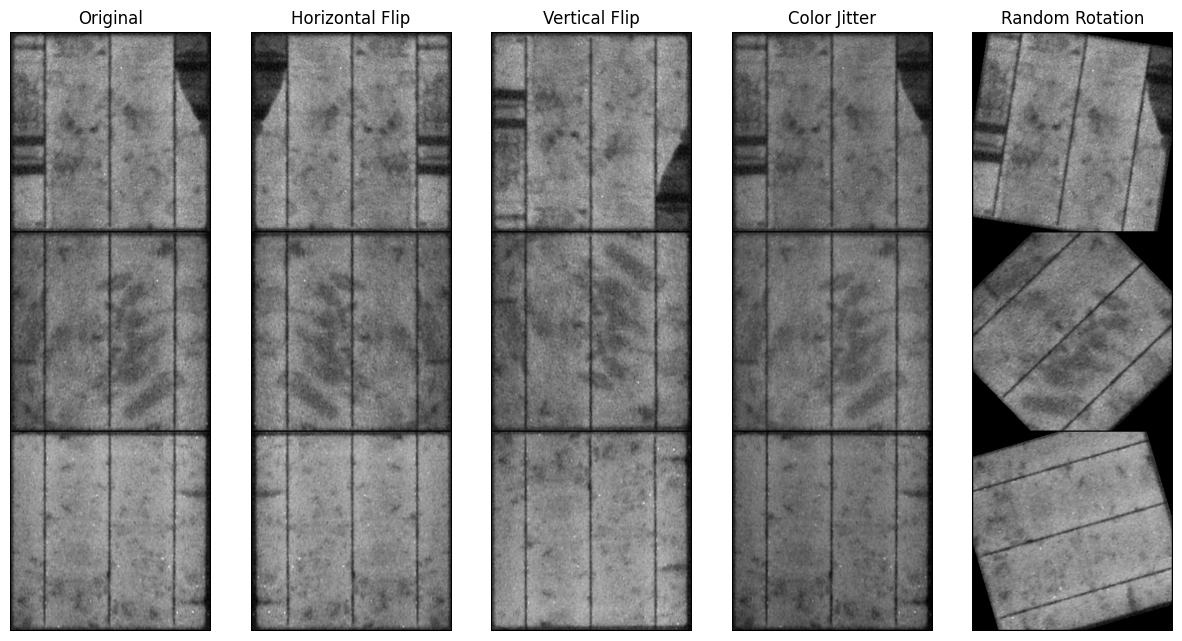

In [58]:
plt.rcParams['figure.figsize'] = [15,12]
# Get a batch of training data
inputs, classes = good_it,1#next(iter(train_loader))
titles = ['Original','Horizontal Flip','Vertical Flip','Color Jitter','Random Rotation','Random Crop']
fig,ax = plt.subplots(1,len(t_forms))
for idx,trans in enumerate(t_forms): 
    ax[idx].axis('off')
    transformed_image = [trans(inputs[i]) for i in range(len(inputs))] if trans is not None else inputs
    out = torchvision.utils.make_grid(transformed_image,nrow = 1)
    out = out.numpy().transpose((1, 2, 0))
    out = np.clip(out, 0, 1)
    ax[idx].imshow(out)
    ax[idx].set_title(titles[idx])

In [47]:
t_forms[1].__repr__()

'RandomHorizontalFlip(p=0.5)'

# Mixup examples: 

In [61]:
def mixup_data(x, y, alpha=1.0, use_cuda=False):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [66]:
inputs, targets_a, targets_b, lam = mixup_data(inputs,torch.tensor([1,0,0]))

In [91]:
out = torchvision.utils.make_grid(inputs,nrow = 3)

In [89]:
out_org = torchvision.utils.make_grid(good_it,nrow = 3) 
#c_mix = torch.hstack([out_org,out])

In [96]:
from matplotlib.patches import BoxStyle


class MyRArrow(BoxStyle.RArrow):
        def __init__(self, pad=0.3, width=220):
            self.width_ = width
            super(MyRArrow, self).__init__(pad)

        def transmute(self, x0, y0, width, height, mutation_size):
            p = BoxStyle.RArrow.transmute(self, x0, y0,
                                          width, height, mutation_size)
            x = p.vertices[:, 0]
            p.vertices[1:3, 0] = x[1:3] - self.width_
            p.vertices[0, 0]   = x[0]   + self.width_
            p.vertices[3:, 0]  = x[3:]  + self.width_
            return p

BoxStyle._style_list["myrarrow"] = MyRArrow

In [108]:
bbox_props = dict(boxstyle="myrarrow,pad=0.2, width=150", fc="White", ec="b", lw=1)

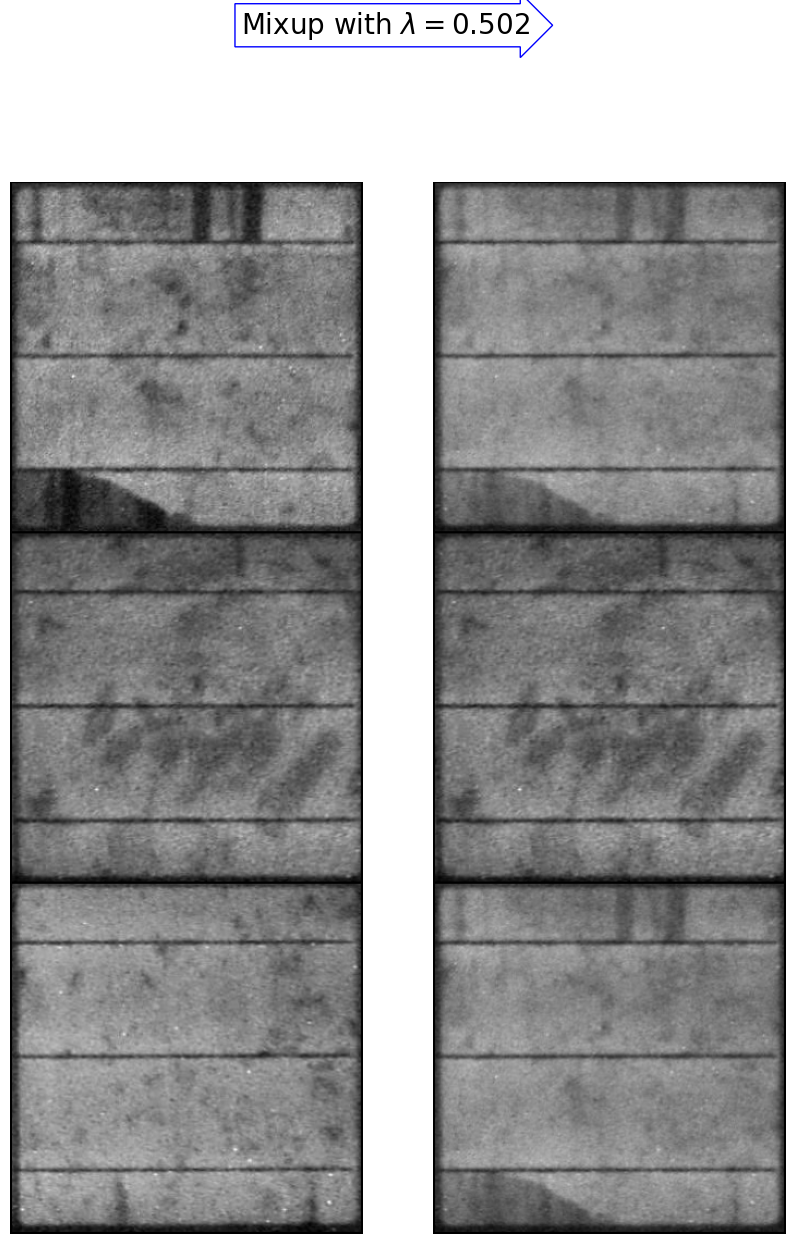

In [109]:
fig,ax = plt.subplots(1,2,figsize = [10,15])

ax[0].imshow(out_org.T)
ax[0].axis('off')
ax[0].set_aspect('equal')
ax[0].text(0.5, 0.95, f"Mixup with $\lambda = {np.round(lam,3)}$", ha="center", va="center", 
                rotation=0, size=20, bbox=bbox_props, transform=fig.transFigure)

ax[1].imshow(out.T)
ax[1].axis('off')
ax[1].set_aspect('equal')

# Own models

In [250]:
class VariableConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, conv_layers):
        super(VariableConvNet, self).__init__()
        
        self.conv_layers = conv_layers
        self.conv = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.pool = nn.ModuleList()
        self.relu = nn.ReLU(inplace=True)
        
        for i in range(conv_layers):
            if i == 0:
                self.conv.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
            else:
                self.conv.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
            
            self.bn.append(nn.BatchNorm2d(out_channels))
            self.pool.append(nn.MaxPool2d(kernel_size=2, stride=1))
        self.fc = None
        
    def forward(self, x):
        for i in range(self.conv_layers):
            x = self.conv[i](x)
            x = self.bn[i](x)
            x = self.relu(x)
            x = self.pool[i](x)
        
        x = x.view(x.size(0), -1)
        
        #Set the linear shape dependent on the shape of the output of the first forward pass
        if self.fc is None:
            self.fc = nn.Linear(x.shape[1], 2)
        x = self.fc(x)
        
        return x

In [261]:
model = VariableConvNet(in_channels=3, out_channels=16, conv_layers=7)

In [51]:
#model = SmallCNN()
model = models.mobilenet_v2(weights = None)
# Modify the first layer to accept input of size 320x320x3
model.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the last layer to output a tensor of shape (batch_size, 2)
model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)

In [52]:
criterion = nn.BCEWithLogitsLoss(weight=loss_weights.to(device), reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [53]:
def plot_conf_mat(conf_mat):
    disp = ConfusionMatrixDisplay(confusion_matrix=Matrix.cpu().detach().numpy(),
                                      display_labels=['Negative', 'Positive'])
    disp.plot()

In [54]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 40 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [63]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    predictions,labels = [],[]
    c = 0
    with torch.no_grad():
        for X, y in dataloader:
            
            X, y = X.to(device), y.to(device)
            pred = model(X)
            predictions.append(F.softmax(pred,dim = 1))
            labels.append(y)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    confmat = ConfusionMatrix(task="binary", num_classes=2, threshold=float(0.5)).to(device)
    predictions = torch.vstack(predictions)
    labels = torch.vstack(labels)
    #print(labels)
    #print(predictions)
    cm = confmat(predictions[:,1],labels[:,1])
    
    print(cm)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [102]:
epochs = 40
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)
    test(val_loader, model, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.665423  [    8/  656]
loss: 0.671240  [  328/  656]
loss: 0.719053  [  648/  656]
tensor([[5614, 1495],
        [  62,   40]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 502.310889 

Epoch 2
-------------------------------
loss: 0.689844  [    8/  656]
loss: 0.688618  [  328/  656]
loss: 0.579541  [  648/  656]
tensor([[5650, 1459],
        [  60,   42]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 494.903547 

Epoch 3
-------------------------------
loss: 0.658248  [    8/  656]
loss: 0.703142  [  328/  656]
loss: 0.681544  [  648/  656]
tensor([[5249, 1860],
        [  51,   51]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 512.275684 

Epoch 4
-------------------------------
loss: 0.614768  [    8/  656]
loss: 0.763103  [  328/  656]
loss: 0.670772  [  648/  656]
tensor([[5959, 1150],
        [  66,   36]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 452.417125 

Epoch 5
-------------------------------
loss: 0.524048  [    8/  656]
loss: 0.510863  [ 

loss: 0.263648  [    8/  656]
loss: 0.672127  [  328/  656]
loss: 0.454700  [  648/  656]
tensor([[4901, 2208],
        [  33,   69]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 611.616634 

Epoch 38
-------------------------------
loss: 0.480743  [    8/  656]
loss: 0.669396  [  328/  656]
loss: 0.539596  [  648/  656]
tensor([[4673, 2436],
        [  28,   74]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 668.032848 

Epoch 39
-------------------------------
loss: 0.239166  [    8/  656]
loss: 0.298998  [  328/  656]
loss: 0.904283  [  648/  656]
tensor([[5428, 1681],
        [  42,   60]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 489.001810 

Epoch 40
-------------------------------
loss: 0.405056  [    8/  656]
loss: 0.303900  [  328/  656]
loss: 0.940390  [  648/  656]
tensor([[6123,  986],
        [  57,   45]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 356.526418 

Done!


In [103]:
model.eval()
test_loss, correct = 0, 0
predictions,labels = [],[]
c = 0
with torch.no_grad():
    for X, y in val_loader:
        
        X, y = X.to(device), y.to(device)
        pred = model(X)
        predictions.append(F.softmax(pred,dim = 1))
        labels.append(y)
        test_loss += criterion(pred, y).item()
        #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
confmat = ConfusionMatrix(task="binary", num_classes=2, threshold=float(0.5)).to(device)
predictions = torch.vstack(predictions)
labels = torch.vstack(labels)

In [104]:
confmat()

tensor([[9.9970e-01, 2.9985e-04],
        [9.9600e-01, 3.9960e-03],
        [9.6201e-01, 3.7993e-02],
        ...,
        [8.3064e-01, 1.6936e-01],
        [8.4840e-01, 1.5160e-01],
        [8.7408e-01, 1.2592e-01]])

In [105]:
def find_optimal_threshold(precisions, recalls, thresholds):
    """
    Given a list of precisions, recalls, and corresponding thresholds, finds the optimal threshold
    that maximizes the F1 score (harmonic mean of precision and recall).

    Args:
    - precisions (list): A list of precisions.
    - recalls (list): A list of recalls.
    - thresholds (list): A list of thresholds corresponding to the precisions and recalls.

    Returns:
    - The optimal threshold (float).
    """

    # Calculate F1 scores for each threshold
    f1_scores = [2 * (p * r) / (p + r) if p + r > 0 else 0 for p, r in zip(precisions, recalls)]

    # Find the index of the threshold with the highest F1 score
    max_index = f1_scores.index(max(f1_scores))

    # Return the corresponding threshold
    return thresholds[max_index],f1_scores[max_index]

In [106]:
precision, recall, thresholds= precision_recall_curve(labels[:,1].to(int),predictions[:,1])

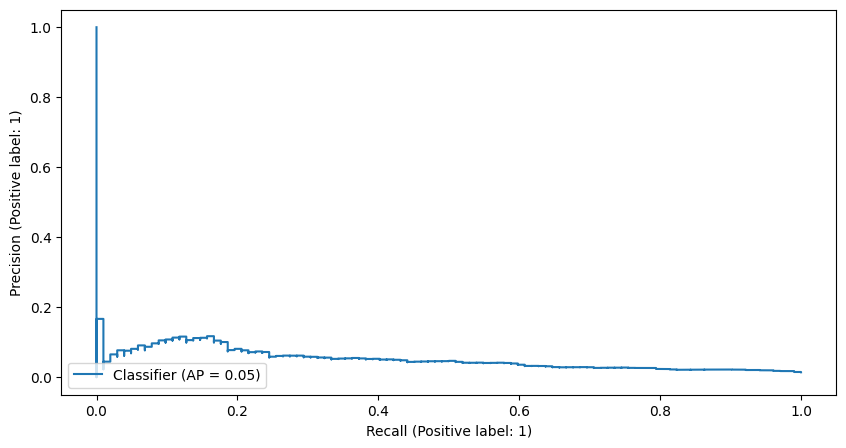

In [163]:
disp = PrecisionRecallDisplay.from_predictions(labels[:,1].to(int),predictions[:,1])

In [108]:
find_optimal_threshold(precision, recall, thresholds)

(0.98468286, 0.1376518218623482)

In [149]:
confmat = ConfusionMatrix(task="binary", num_classes=2, threshold=float(0.5)).to(device)
cm = confmat(predictions[:,1],labels[:,1].to(int))
cm

tensor([[6123,  986],
        [  57,   45]])

In [99]:
test_set = pd.read_csv(f'{root_dir}BachelorProject/Data/VitusData/Test.csv', converters=converters)
test_class = SolarELData(test_set)
test_loader = DataLoader(test_class, batch_size=batch_size_test, shuffle=True)

In [100]:
test(test_loader, model, criterion)

tensor([[5321, 1787],
        [  41,   61]])
Test Error: 
 Accuracy: 0.0%, Avg loss: 536.681514 



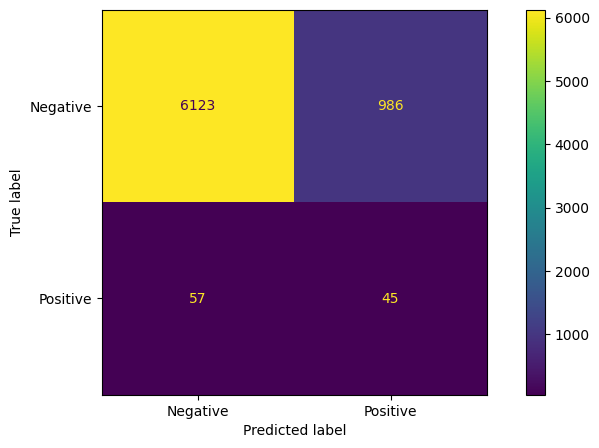

In [164]:
disp = ConfusionMatrixDisplay(cm.numpy(),
                              display_labels=['Negative', 'Positive'])
disp.plot()

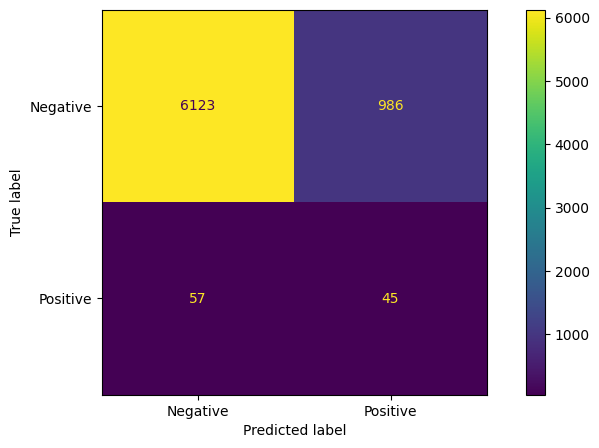

In [167]:
f = disp.plot()

<Axes: >

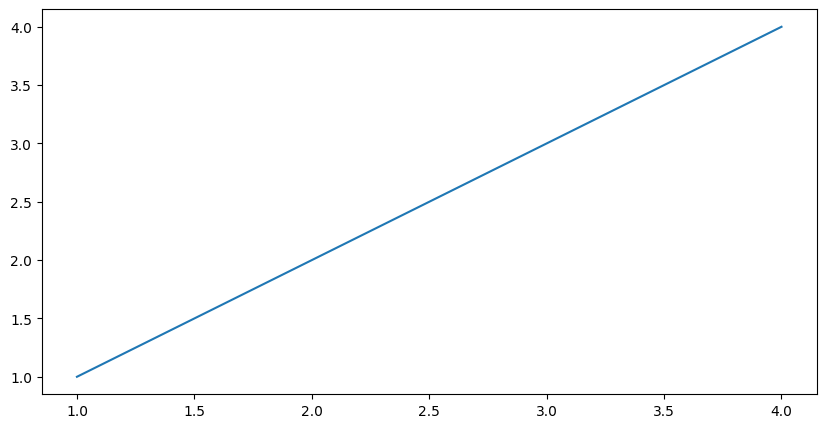

In [173]:
sns.lineplot(x = [1,2,3,4],y =[1,2,3,4])

- Mindre og større modeller 
- Infør syntetisk data, til non-DL
- Se om syntetisk data gør nogen forskel. Prøv evt. at lave et lille syntetisk test-set for at se om modellerne overfitter på artefakter.  
-

## Class activation maps. 

In [87]:
from torchvision.transforms import ToTensor,Resize

In [190]:
class ResnetModules(nn.Module):
    def __init__(self, model):
        super(ResnetModules, self).__init__()
        self.resnet = model
        self.out_dim = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(self.out_dim, 1)
        self.sigmoid = nn.Sigmoid()
        # Change input size to be of size 320x320x1

    def forward(self, x):
        # Resize image to input size of the model
        x = self.resnet(x)
        x = self.sigmoid(x)
        x = torch.ravel(x)
        return x

In [191]:
def loadModel(model):
    model = ResnetModules(model)
    checkpoint = torch.load('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/Models/resnet18_id_6676_epoch_19',map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint)
    return model

In [192]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [193]:
model = models.resnet18(pretrained=False)
model = loadModel(model)
#model.eval()
#model.register_forward_hook(get_activation('layer3'))

In [126]:
model

ResnetModules(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [127]:
test_transform = transforms.Compose(
    [
     transforms.PILToTensor(),
     transforms.ConvertImageDtype(torch.float),
     Resize((420,420)),
     transforms.Normalize((0.51, 0.51, 0.51), (0.15, 0.15, 0.15))
    ]
)
test_set = torchvision.datasets.ImageFolder('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/VitusData/ImageFolderComp/Train',
                                            transform = test_transform)

In [128]:
test_set.targets.index(1)

21031

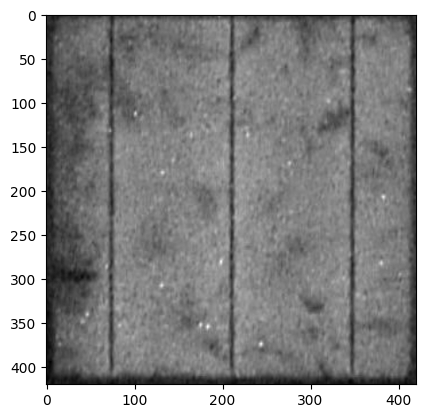

In [179]:
im = test_set[21031][0]
plt.imshow(im[0,:,:],cmap = 'gray')

In [216]:
model.state_dict().keys()

odict_keys(['resnet.conv1.weight', 'resnet.bn1.weight', 'resnet.bn1.bias', 'resnet.bn1.running_mean', 'resnet.bn1.running_var', 'resnet.bn1.num_batches_tracked', 'resnet.layer1.0.conv1.weight', 'resnet.layer1.0.bn1.weight', 'resnet.layer1.0.bn1.bias', 'resnet.layer1.0.bn1.running_mean', 'resnet.layer1.0.bn1.running_var', 'resnet.layer1.0.bn1.num_batches_tracked', 'resnet.layer1.0.conv2.weight', 'resnet.layer1.0.bn2.weight', 'resnet.layer1.0.bn2.bias', 'resnet.layer1.0.bn2.running_mean', 'resnet.layer1.0.bn2.running_var', 'resnet.layer1.0.bn2.num_batches_tracked', 'resnet.layer1.1.conv1.weight', 'resnet.layer1.1.bn1.weight', 'resnet.layer1.1.bn1.bias', 'resnet.layer1.1.bn1.running_mean', 'resnet.layer1.1.bn1.running_var', 'resnet.layer1.1.bn1.num_batches_tracked', 'resnet.layer1.1.conv2.weight', 'resnet.layer1.1.bn2.weight', 'resnet.layer1.1.bn2.bias', 'resnet.layer1.1.bn2.running_mean', 'resnet.layer1.1.bn2.running_var', 'resnet.layer1.1.bn2.num_batches_tracked', 'resnet.layer2.0.conv1

In [222]:
from torchvision.models import resnet18
from torchcam.methods import CAM
model = models.resnet18(pretrained=False)
model = loadModel(model)
cam = CAM(model, 'resnet')
with torch.no_grad(): out = model(im[None,:,:,:])
cam(class_idx=0)

[tensor([nan])]

In [204]:
model

ResnetModules(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [185]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.methods import SSCAM

In [197]:
cam_extractor = SmoothGradCAMpp(model)

In [182]:
model.train()
for param in model.parameters():
    param.requires_grad = True

In [198]:
with SmoothGradCAMpp(model) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model(im.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

RuntimeError: cannot register a hook on a tensor that doesn't require gradient

# Custom augmentations 

In [64]:
class ZeroPad(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image):
        max_widt, max_height = self.size[0],self.size[1]
        width, height = image.shape[2], image.shape[1]
        pad_widt, pad_height = max_widt - width, max_height - height
        image = transforms.Pad((0,0, pad_widt, pad_height), padding_mode='constant')(image)
        return image

In [63]:
# Example usage:
image = torch.randn(3, 320, 320)  # Example image tensor
target_size = (420,420)  # Desired size for padding

transform = ZeroPad(target_size)
transform(image).shape

torch.Size([3, 420, 420])


torch.Size([3, 420, 420])

In [58]:
padded_image.shape

torch.Size([3, 520, 320])

In [41]:
max_widt, max_height = 430, 430
width, height = image.shape[2], image.shape[1]
pad_widt, pad_height = max_widt - width, max_height - height
image = transforms.Pad((0, 0, pad_widt, pad_height), padding_mode='constant')(image)

In [42]:
image.shape

torch.Size([3, 430, 430])

# Expand data-set

In [235]:
converters = {
    'Label': lambda x: ast.literal_eval(x),
    'MaskDir': lambda x: ast.literal_eval(x) if str(x) != 'nan' else x
}
data = pd.read_csv('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/VitusData/TrainVitusStat.csv',
                  converters =converters)

In [252]:
df = pd.DataFrame()
for idx,row in data.iterrows():
    labels = row['Label']
    if len(labels) > 1:
        for label in labels:
            new_rows = {'ImageDir':[row['ImageDir']],
                        'Label':[label],
                        'MaskDir':[row['MaskDir']]}
            new_rows = pd.DataFrame(new_rows)
    else:
        new_rows = {'ImageDir':[row['ImageDir']],
                    'Label':[labels[0]],
                    'MaskDir':[row['MaskDir']]}
        
        new_rows = pd.DataFrame(new_rows)
    
    df = pd.concat([df,new_rows], ignore_index=True)

In [253]:
len(df)

21631

In [256]:
df.to_csv('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/VitusData/TrainVitusStatExpanded.csv')

# Test expansion 

In [3]:
train_set = torchvision.datasets.ImageFolder('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/Synthetic/Gaussian/ImageFolderComp')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/Synthetic/Gaussian/ImageFolderComp'

In [261]:
len(train_set.targets)

18912

# Test Custom random sampler 

In [4]:
import torch
import torch.utils.data as data
import numpy as np
import torchvision

In [62]:
test_transform = transforms.Compose(
    [
     transforms.PILToTensor(),
     transforms.ConvertImageDtype(torch.float),
     transforms.Resize((224,224)),#ZeroPad((430,430))
     transforms.Normalize((0.51, 0.51, 0.51), (0.15, 0.15, 0.15))
    ]
)

In [63]:
train_set = torchvision.datasets.ImageFolder('/Users/madsandersen/PycharmProjects/BscProjektData/BachelorProject/Data/VitusData/ImageFolderComp/Train',
                                            transform = test_transform)

In [36]:
class CustomRandomSampler(data.Sampler):
    def __init__(self, dataset, initial_weights):
        self.dataset = dataset
        self.initial_weights = initial_weights
        self.num_samples = len(dataset)
        self.indices = np.arange(self.num_samples)
        self.weights = np.copy(initial_weights)
        self.sampled_indices = []

    def __iter__(self):
        self.sampled_indices = np.random.choice(self.indices, size=self.num_samples, replace=True, p=self.weights)
        return iter(self.sampled_indices)

    def __len__(self):
        return self.num_samples

    def update_weights(self, predictions, temperature=1.0):
        # Calculate the entropy of predictions for each sample
        softmax_probs = torch.nn.functional.softmax(predictions / temperature, dim=1)
        entropy = -torch.sum(softmax_probs * torch.log2(softmax_probs), dim=1).numpy()

        # Update the weights based on entropy
        self.weights = np.exp(-entropy)
        self.weights /= np.sum(self.weights)  # Normalize the weights

    def reset_weights(self):
        self.weights = np.copy(self.initial_weights)


In [57]:
sampler = CustomRandomSampler(train_set, [1/len(train_set)]*len(train_set))


NameError: name 'CustomRandomSampler' is not defined

In [59]:
loader = data.DataLoader(train_set, batch_size=8)

In [41]:
for y,X in loader:
    print(X)
    print(y)
    break

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([[[[-3.1124, -2.9098, -2.6795,  ..., -2.8449, -2.8949, -2.9817],
          [-3.0156, -2.6982, -2.3752,  ..., -2.7757, -2.7887, -2.8295],
          [-2.8507, -2.3906, -1.9540,  ..., -2.7423, -2.7172, -2.7110],
          ...,
          [-1.9584, -1.9295, -1.9062,  ..., -2.2102, -2.2927, -2.3784],
          [-1.8621, -1.8604, -1.8590,  ..., -2.2102, -2.3052, -2.4065],
          [-1.7791, -1.8080, -1.8314,  ..., -2.2102, -2.3052, -2.4065]],

         [[-3.1124, -2.9098, -2.6795,  ..., -2.8449, -2.8949, -2.9817],
          [-3.0156, -2.6982, -2.3752,  ..., -2.7757, -2.7887, -2.8295],
          [-2.8507, -2.3906, -1.9540,  ..., -2.7423, -2.7172, -2.7110],
          ...,
          [-1.9584, -1.9295, -1.9062,  ..., -2.2102, -2.2927, -2.3784],
          [-1.8621, -1.8604, -1.8590,  ..., -2.2102, -2.3052, -2.4065],
          [-1.7791, -1.8080, -1.8314,  ..., -2.2102, -2.3052, -2.4065]],

         [[-3.1124, -2.9098, -2.6795,  ..., -2.8449, -2.8949, -2.9817

In [39]:
sampler.sampled_indices

21631

In [40]:
len(train_set)

21631

## Vision transformer 

In [60]:
loader = data.DataLoader(train_set, batch_size=8)

In [11]:
model = torchvision.models.vit_b_16()

In [31]:
class VIT_B_16(nn.Module):
    def __init__(self, num_classes):
        super(VIT_B_16, self).__init__()

        # Load pre-trained ResNet-50 backbone
        self.backbone = resnet50(pretrained=False)

        # Adjust input size of the backbone
        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove fully connected layer and average pooling layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Add a self-attention module
        self.self_attention = nn.MultiheadAttention(embed_dim=2048, num_heads=8)

        # Classification head
        self.classifier = nn.Linear(2048, 1)

        # Activation function
        self.activation = nn.ReLU()

    def forward(self, x):
        # Extract features using the backbone
        features = self.backbone(x)

        # Reshape features for self-attention
        b, c, h, w = features.size()
        features = features.view(b, c, -1).permute(2, 0, 1)

        # Apply self-attention
        self_attention_output, _ = self.self_attention(features, features, features)
        self_attention_output = self_attention_output.permute(1, 2, 0).view(b, c, h, w)

        # Global average pooling
        pooled_output = self_attention_output.mean(dim=(2, 3))

        # Apply classification head
        logits = self.classifier(pooled_output)

        # Apply activation function
        logits = self.activation(logits)

        return logits

In [32]:
model = VIT_B_16(2)

In [64]:
im = train_set[0][0]

In [65]:
model(im[None,:,:,:])

tensor([[0.1684]], grad_fn=<AddmmBackward0>)

In [72]:
class VIT_B_16(nn.Module):
    def __init__(self, model, num_classes):
        super(VIT_B_16, self).__init__()

        # Load the pre-trained VIT-B-16 model
        self.model = model

        self.model.heads.head = nn.Linear(in_features=768, out_features=1, bias=True)

        # Activation function
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through the modified model
        logits = self.model(x)

        # Apply activation function
        logits = self.activation(logits)
        logits =  self.sigmoid(logits)

        return logits

In [73]:
model = torchvision.models.vit_b_16()
net = VIT_B_16(model,2)

In [76]:
net(im[None,:,:,:])

tensor([[0.5446]], grad_fn=<SigmoidBackward0>)

In [69]:
vit_b_16(weights='IMAGENET1K_V1')

NameError: name 'vit_b_16' is not defined